# Elevrad, toporad and stoporad

Ensure that the conversion of the 3 functions to Python match with the IPW versions

In [1]:
import os
import netCDF4 as nc
import pandas as pd
import numpy as np
import subprocess as sp
from spatialnc import ipw
from spatialnc.topo import get_topo_stats
import matplotlib.pyplot as pltW
import seaborn as sns

from smrf.envphys.solar import toporad, irradiance

sns.set_context('poster')

In [2]:
# create an IPW DEM image for the Lakes

# Load the netcdf dem and get all the geo coords for IPW
topo_path = '../tests/Lakes/topo/topo.nc'

d = nc.Dataset(topo_path)
dem = np.round(d.variables['dem'][:])
d.close()

ts = get_topo_stats(topo_path)

csys = 'UTM'
nbits = 16

# Create the IPW image
i = ipw.IPW()
i.new_band(dem)
i.add_geo_hdr(
    coordinates=[ts['u'], ts['v']],
    d=[ts['dv'], ts['du']],
    units=ts['units'],
    csys=csys
)

i.write(
    'lakes_dem.ipw',
    nbits=nbits
)


In [3]:
# Parameters for elevrad, toporad and stoporad

date_time = pd.to_datetime('2/15/1990 20:30')
date_time = date_time.tz_localize('UTC')

cosz = 0.45
tau_elevation = 100
tau = 0.2
omega = 0.85
scattering_factor = 0.3
surface_albedo = 0.5
solar_irradiance = irradiance.direct_solar_irradiance(
    date_time, w=[0.28, 2.8])


elevrad -z 100 -t 0.2 -w 0.85 -g 0.3 -r 0.5 -s 1321.0014737319768 -u 0.45 -n 16 lakes_dem.ipw > elevrad.ipw


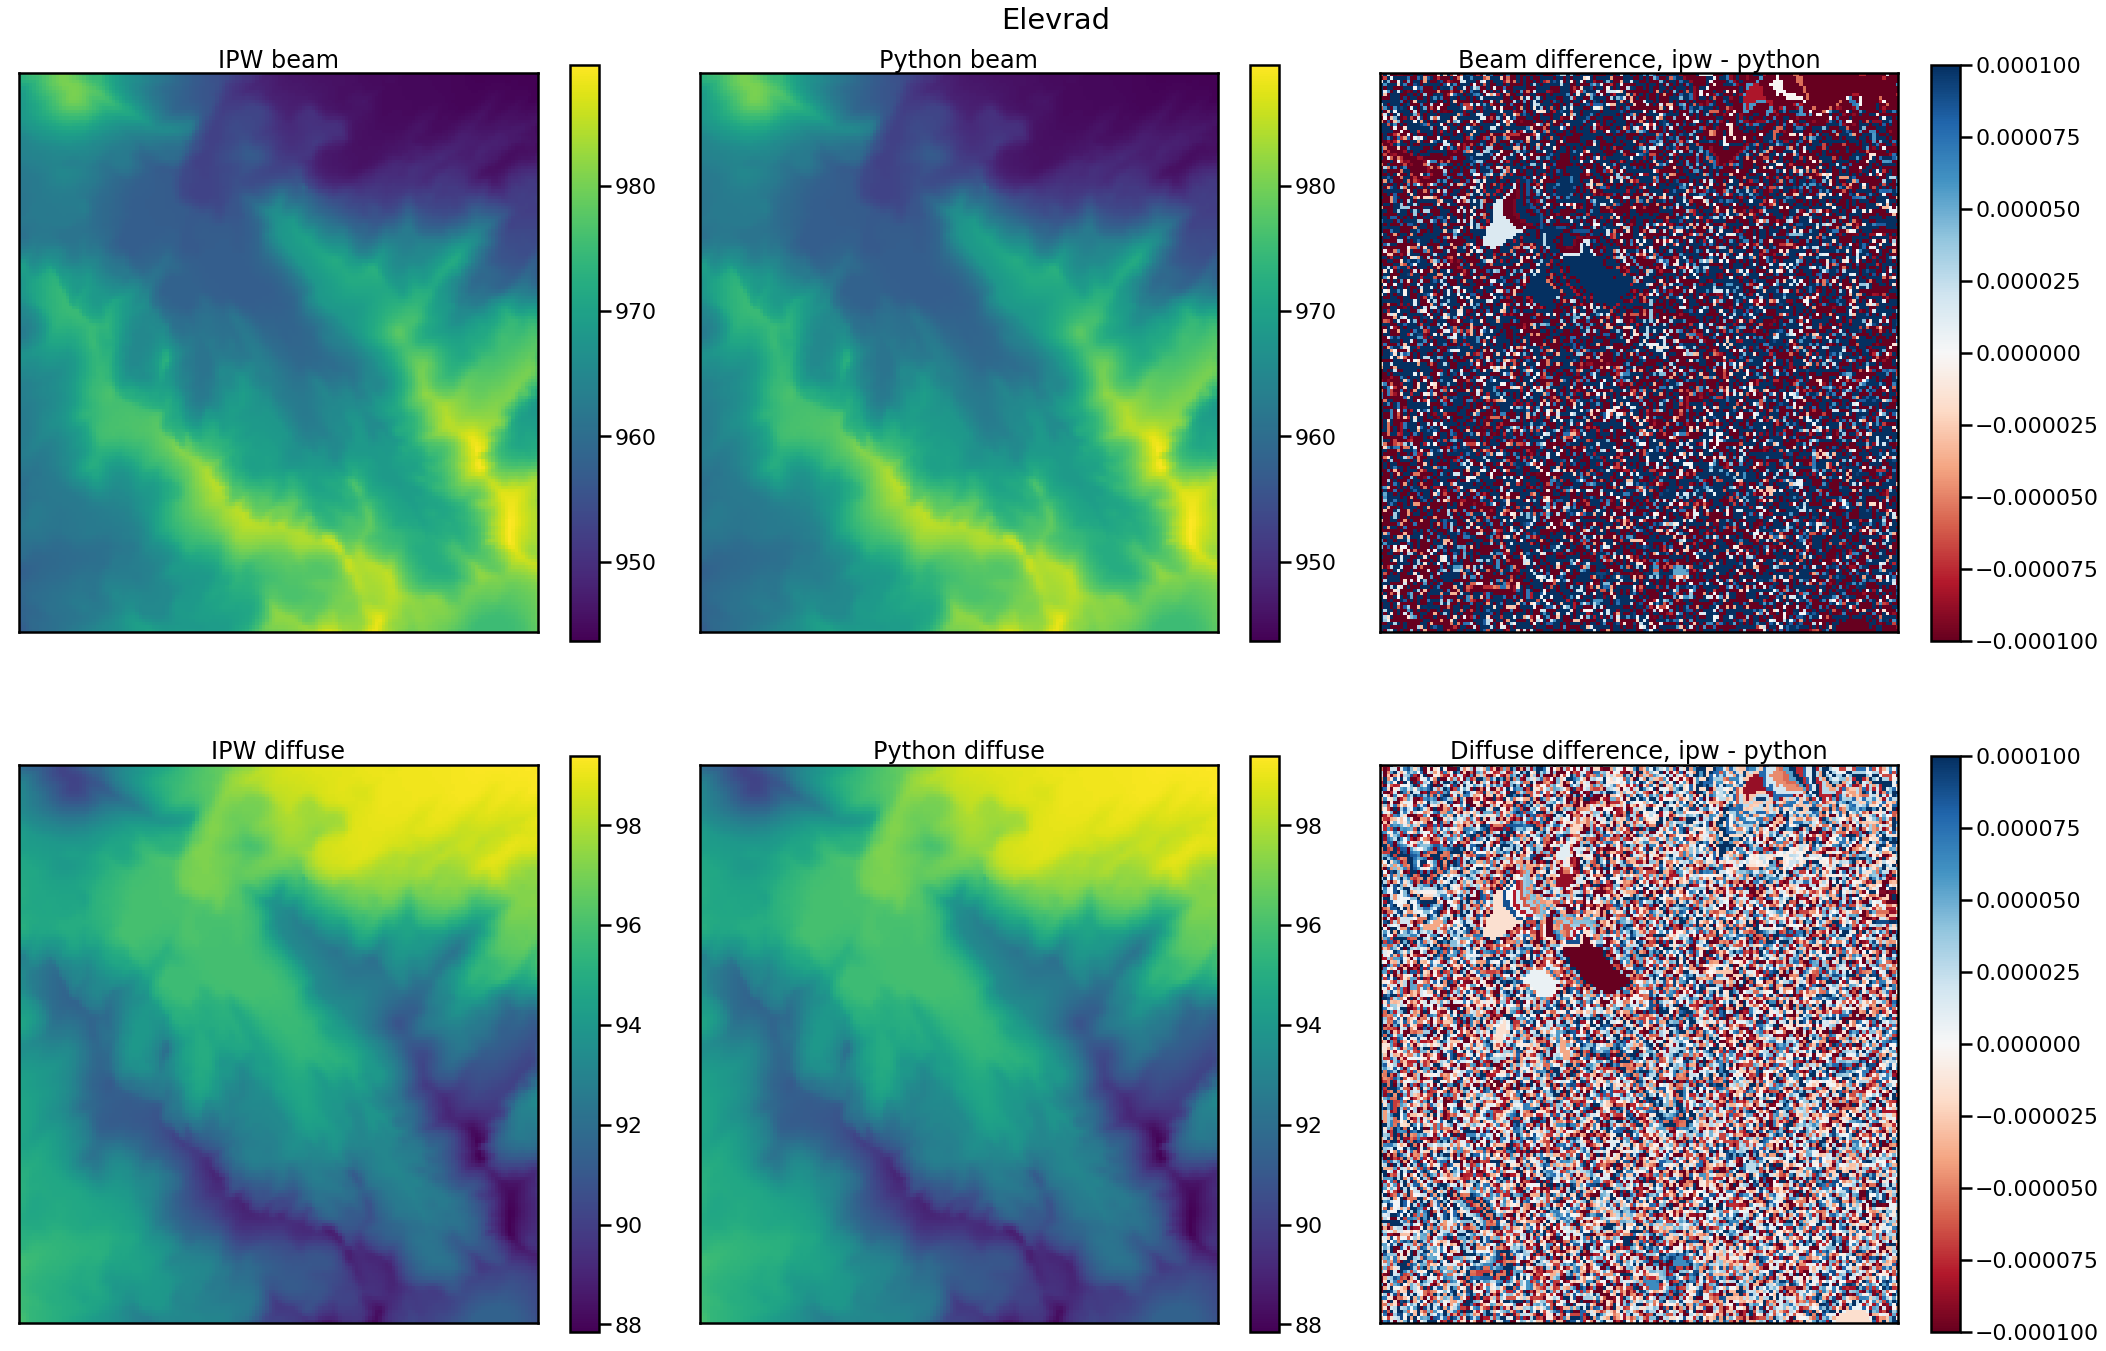

In [4]:
# Elevrad
# The only difference is bit resolution noise

cmd = f"elevrad -z {tau_elevation} -t {tau} -w {omega} -g {scattering_factor} -r {surface_albedo} -s {solar_irradiance} -u {cosz} -n 16 lakes_dem.ipw > elevrad.ipw"

print(cmd)
visp = sp.Popen(cmd, shell=True)
visp.wait()

elevrad_ipw = ipw.IPW('elevrad.ipw')

elevrad_py = toporad.Elevrad(
    dem,
    solar_irradiance,
    cosz)

fig, ax = plt.subplots(2, 3, figsize = (30, 20))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.05)
fig.suptitle('Elevrad')

# IPW originals
im0 = ax[0, 0].imshow(elevrad_ipw.bands[0].data)
ax[0, 0].set_title('IPW beam')
fig.colorbar(im0, ax=ax[0, 0])

im0 = ax[1, 0].imshow(elevrad_ipw.bands[1].data)
ax[1, 0].set_title('IPW diffuse')
fig.colorbar(im0, ax=ax[1, 0])

# Python elevrad
im0 = ax[0, 1].imshow(elevrad_py.beam)
ax[0, 1].set_title('Python beam')
fig.colorbar(im0, ax=ax[0, 1])

im0 = ax[1, 1].imshow(elevrad_py.diffuse)
ax[1, 1].set_title('Python diffuse')
fig.colorbar(im0, ax=ax[1, 1])

# difference
d = elevrad_ipw.bands[0].data - elevrad_py.beam
var_lim = max([abs(d.min()), abs(d.max())])
var_lim = 1e-4
im2 = ax[0, 2].imshow(d, cmap='RdBu', vmin=-var_lim, vmax=var_lim)
ax[0, 2].set_title('Beam difference, ipw - python')
fig.colorbar(im2, ax=ax[0, 2])

d = elevrad_ipw.bands[1].data - elevrad_py.diffuse
var_lim = max([abs(d.min()), abs(d.max())])
var_lim = 1e-4
im2 = ax[1, 2].imshow(d, cmap='RdBu', vmin=-var_lim, vmax=var_lim)
ax[1, 2].set_title('Diffuse difference, ipw - python')
fig.colorbar(im2, ax=ax[1, 2])

# remove the x and y ticks
for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])
    
os.remove('elevrad.ipw')

In [14]:
os.remove('lakes_dem.ipw')